In [2]:
import numpy as np # для работы с массивами
import pandas as pd # для работы DataFrame
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline


In [3]:
df = pd.read_csv('source.csv')
del df['Serial No.']


1. GRE Scores ( out of 340 ) — баллы по GRE тестированию
2. TOEFL Scores ( out of 120 ) — баллы по экзамену TOEFL
3. University Rating ( out of 5 ) — рейтинг университета
4. Statement of Purpose Strength ( out of 5 ) — весомость мотивационного письма
5. Letter of Recommendation Strength ( out of 5 ) — весомость рекомендационных писем
6. Undergraduate GPA ( out of 10 ) — средний балл в бакалавриате
7. Research Experience ( either 0 or 1 ) — наличие опыта исследовательской работы ( нет / есть)


<AxesSubplot:>

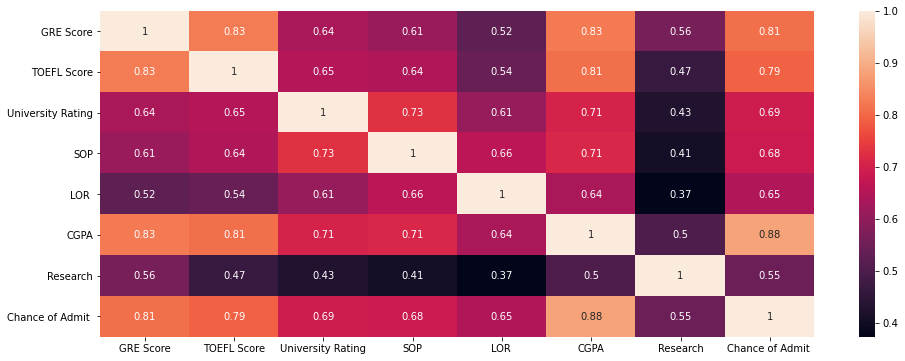

In [4]:
c_dict = {} # словарь для хранения и обращения к коэффициентам
            # (среднее и длина вектора для нормирования)

df.columns

plt.figure(figsize=(16,6))
sns.heatmap(data=df.corr(method='pearson'), annot=True)

Research=1

<AxesSubplot:>

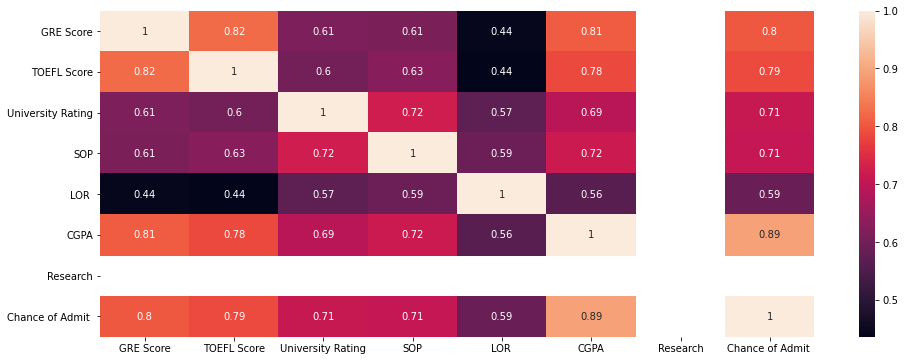

In [5]:
plt.figure(figsize=(16,6))
sns.heatmap(data=df.query('Research == 1').corr(method='pearson'), annot=True)

Research=0

<AxesSubplot:>

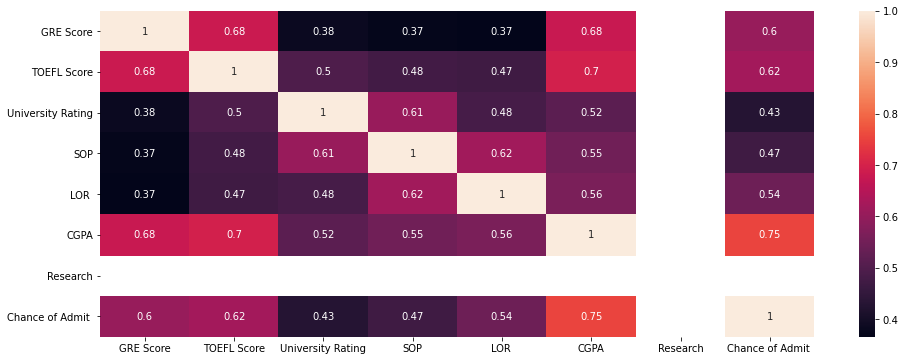

In [6]:
plt.figure(figsize=(16,6))
sns.heatmap(data=df.query('Research == 0').corr(method='pearson'), annot=True)

ols регрессия для признаков toefl score, cgpa, для студентов с reshearch == 0

In [7]:
df.columns
df['Const'] = 1
y = df.query('Research == 0')['Chance of Admit ']
A = df.query('Research == 0')[['Const', 'TOEFL Score', 'CGPA']]

print(np.linalg.lstsq(A,y, rcond=None))
df.columns

(array([-1.04486443,  0.00442727,  0.14807744]), array([1.13772786]), 3, array([1.54898055e+03, 5.02503482e+00, 6.75329627e-01]))


Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit ', 'Const'],
      dtype='object')

прогноз

In [8]:
TOEFL = 107
CGPA = 9.1

score = -1.04486443 + 0.00442727 * TOEFL + 0.14807744 * CGPA
print(score)

0.7763581639999998


ols регрессия для стандартизированных признаков

In [9]:
def normalize_df(df, c_dict):
    df_result = pd.DataFrame()
    for col_name in df.columns:
        c_dict[col_name] = {
            'mean': df[col_name].mean(),
            'norm': np.linalg.norm(df[col_name] - df[col_name].mean())
        }
        df_result[col_name] = df[col_name].apply(lambda x: (x - c_dict[col_name]['mean'])
                                                           / c_dict[col_name]['norm'])
    return df_result

df_std = normalize_df(df.query('Research == 0')[['Chance of Admit ', 'TOEFL Score', 'CGPA']], c_dict)

y = df_std['Chance of Admit ']
A = df_std[['TOEFL Score', 'CGPA']]

print(np.linalg.lstsq(A,y, rcond=None))

(array([0.19044768, 0.62001517]), array([0.41476017]), 2, array([1.30260267, 0.55065986]))


прогноз для стандартизированных значений



In [10]:
TOEFL = 107
CGPA = 9.1

score = 0.19044768 * (TOEFL - c_dict['TOEFL Score']['mean'])/c_dict['TOEFL Score']['norm'] \
        + 0.62001517 * (CGPA - c_dict['CGPA']['mean'])/c_dict['CGPA']['norm']

print(score * c_dict['Chance of Admit ']['norm'] + c_dict['Chance of Admit ']['mean'])

0.7763585310402557


In [99]:
test = np.array([[1,2,1,1],[70,130,65,60]]).T

df = pd.DataFrame(test, columns=['x1', 'x2'])

c_dict = {}
df_std = normalize_df(df, c_dict)

print(df_std)

# находим координаты собственного вектор для наибольшего
# собственного числа матрицы корреляций
A = np.array(
    [[1, 0.9922],
    [0.9922, 1],
]) # создаем матрицу 3х3
B = np.linalg.eig(A)

print(B[1][1,:])

d1 = B[1][1,0]
d2 = B[1][1,1]

df_std['new'] = df_std.apply(lambda x: d1*x[0] + d2*x[1], axis=1)

df_std['new_std'] = df_std['new'].apply(lambda x: x/(1.991**(1/2))).round(4)

print(df_std['new'])
print(df_std['new_std'])

         x1        x2
0 -0.288675 -0.198294
1  0.866025  0.859273
2 -0.288675 -0.286424
3 -0.288675 -0.374555
[0.70710678 0.70710678]
0   -0.344339
1    1.219970
2   -0.406657
3   -0.468974
Name: new, dtype: float64
0   -0.2440
1    0.8646
2   -0.2882
3   -0.3324
Name: new_std, dtype: float64
